<a href="https://colab.research.google.com/github/smsali97/cybersecurity-analytics-cmpe788/blob/main/Finding%20Network%20Attack%20Type%20through%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the Attack Type using Clustering ( K Means Clustering)

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [26]:
hulk_df = pd.read_csv('Hulk-NoDefense.csv')
slowhttp_df = pd.read_csv('Slowhttptest-NoDefense.csv')
slowloris_df = pd.read_csv('Slowloris-NoDefense.csv')
tcpflood_df = pd.read_csv('TCPFlood-NoDefense(2).csv')

In [27]:
# checking if columns are the same
hulk_columns = set(hulk_df)
slowhttp_columns = set(slowhttp_df)
slowloris_columns = set(slowloris_df)
tcpflood_columns = set(tcpflood_df)

hulk_columns == slowhttp_columns == slowloris_columns == tcpflood_columns

True

In [28]:
# adding target column
hulk_df['attack_type'] = 'hulk'
slowhttp_df['attack_type'] = 'slow_http'
slowloris_df['attack_type'] = 'slow_loris'
tcpflood_df['attack_type'] = 'tcp_flood'

In [29]:
df = pd.concat([hulk_df,slowhttp_df,slowloris_df,tcpflood_df])
df.sample(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,attack_type
263714,192.168.111.65-192.168.111.66-33476-80-6,192.168.111.65,33476,192.168.111.66,80,6,11/02/2021 09:25:24 AM,19198,24,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCPFlood-NoDefense,tcp_flood
244573,192.168.111.65-192.168.111.66-57734-80-6,192.168.111.65,57734,192.168.111.66,80,6,11/02/2021 09:24:23 AM,19078,25,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCPFlood-NoDefense,tcp_flood
33058,192.168.111.65-192.168.111.66-44358-80-6,192.168.111.65,44358,192.168.111.66,80,6,11/02/2021 09:04:14 AM,113180,9,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
241848,192.168.111.65-192.168.111.66-42584-80-6,192.168.111.65,42584,192.168.111.66,80,6,11/02/2021 09:06:34 AM,710425,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
158164,192.168.111.65-192.168.111.66-43102-80-6,192.168.111.65,43102,192.168.111.66,80,6,11/02/2021 09:05:37 AM,160895,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk


In [30]:
df.isna().sum()

Flow ID        0
Src IP         0
Src Port       0
Dst IP         0
Dst Port       0
              ..
Idle Std       0
Idle Max       0
Idle Min       0
Label          0
attack_type    0
Length: 85, dtype: int64

In [31]:

le = LabelEncoder()

print('All possible IPs: ',set(df['Src IP']) | set(df['Dst IP']))

df = df.drop(columns=['Src IP','Dst IP', 'Src Port', 'Dst Port'],axis=1)
# drop ip address ports

All possible IPs:  {'192.168.111.6', '192.168.111.250', '0.0.0.0', '192.168.111.66', '192.168.111.255', '192.168.111.68', '192.168.111.199', '192.168.111.65', '255.255.255.255', '*.*.*.*'}


In [32]:
df.isna().sum()
# dropping these columns, can later analyse if they are useful
df.drop(columns=['Flow ID','Label','Timestamp'],inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151492 entries, 0 to 291759
Data columns (total 78 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Protocol                    1151492 non-null  int64  
 1   Flow Duration               1151492 non-null  int64  
 2   Total Fwd Packet            1151492 non-null  int64  
 3   Total Bwd packets           1151492 non-null  int64  
 4   Total Length of Fwd Packet  1151492 non-null  float64
 5   Total Length of Bwd Packet  1151492 non-null  float64
 6   Fwd Packet Length Max       1151492 non-null  float64
 7   Fwd Packet Length Min       1151492 non-null  float64
 8   Fwd Packet Length Mean      1151492 non-null  float64
 9   Fwd Packet Length Std       1151492 non-null  float64
 10  Bwd Packet Length Max       1151492 non-null  float64
 11  Bwd Packet Length Min       1151492 non-null  float64
 12  Bwd Packet Length Mean      1151492 non-null  float64
 13

In [34]:
df = df.dropna() # drop na values can handle as well

train_df, test_df = train_test_split(df, test_size=0.3, random_state=633, shuffle=True)

In [35]:
attack_types = ['hulk','slow_http','slow_loris','tcp_flood']




train_df_output = train_df['attack_type']
train_df_input =  train_df.drop(['attack_type'],axis=1)

scaler = MinMaxScaler()
train_df_input = scaler.fit_transform(train_df_input) # min max scaler, ideally need to customize


kmeans = KMeans(n_clusters=len(attack_types))
kmeans = kmeans.fit(train_df_input)




## Plotting 2D Scatter Plot (Dimensionality Reduction) for visualising class distinction of attack types

['hulk: red', 'slow_http: blue', 'slow_loris: green', 'tcp_flood: black']


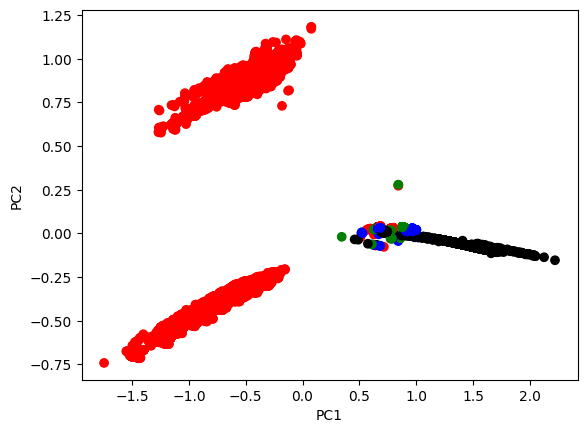

Hulk is significantly different from other attacks, also tcp flood is on the extreme end as well


In [36]:
pca = PCA()
x_new = pca.fit_transform(train_df_input)


color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'black'}
colors = [color_map[attack_types.index(i)] for i in train_df_output]

print([attack_types[i] + ': ' + color_map[i] for i in range(len(attack_types))])
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('Hulk is significantly different from other attacks, also tcp flood is on the extreme end as well')

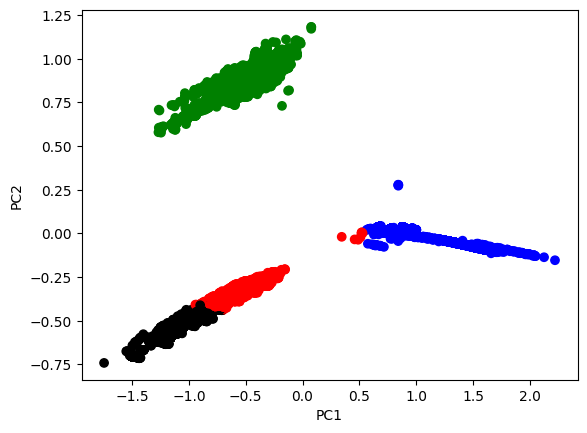

In [37]:

colors = [color_map[i] for i in kmeans.labels_]
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Using Support Vector Machine to identify Decision Bounaries

In [38]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(train_df_input,train_df_output)

test_df_output = test_df['attack_type']
test_df_input =  test_df.drop(['attack_type'],axis=1)

scaler = MinMaxScaler()
test_df_input = scaler.fit_transform(test_df_input) # min max scaler, ideally need to customize

predicted_test_df_output = clf.predict(test_df_input)

# Results

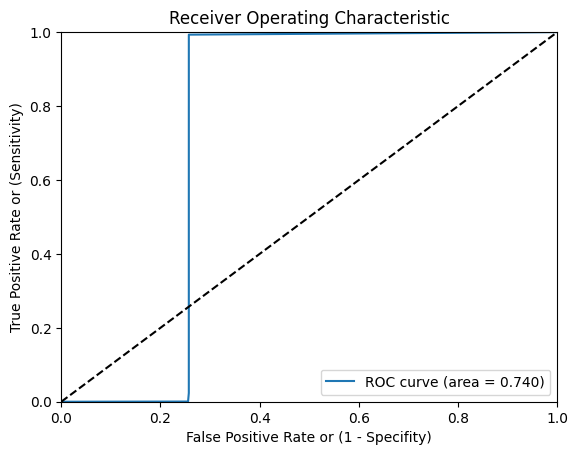

In [39]:
# Compute fpr, tpr, thresholds and roc auc
y_true = [attack_types.index(a) for a in test_df_output ]
y_score = [attack_types.index(a) for a in predicted_test_df_output ]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")